# Example 3: Acceleration due to gravity

To illustrate how to use `emulator` and `calibrator` objects, we will give another example of a free-falling objects.

First, import the main libraries we use for this example:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as sps
from surmise.emulation import emulator
from surmise.calibration import calibrator

## Data: Falling ball

The data include 63 field observations at 21 heights, with three replicates at each height. Let's read the real data first, and then visualize:

In [2]:
# Read the data
ball = np.loadtxt('ball.csv', delimiter=',')
m = len(ball)
# height
xrep = np.reshape(ball[:, 0], (m, 1))
x = xrep[0:21]
# time
y = np.reshape(ball[:, 1], ((m, 1)))
y = y[0:21]

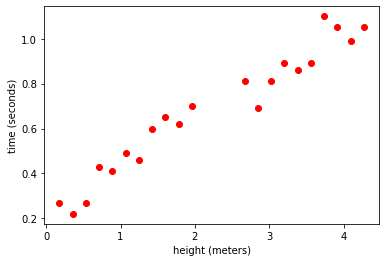

In [3]:
# Observe the data
plt.scatter(x, y, color='red')
plt.xlabel("height (meters)")
plt.ylabel("time (seconds)")
plt.show()

## Computer model experiments

The time $t$ to drop the ball at a distance $h$ is $t = \sqrt{2h/g}$ for gravity $g$. Here, the gravity $g$ is our calibration parameter $\theta$ bacause we don't know the actual value of $g$ for the location the ball is dropped. We consider the computer implementation $f(x, \theta)$ of the mathematical model that maps $(h, g)$ to $(x, \theta)$ in $[0, 1]$ to compute $t$. 

In [4]:
# Computer implementation of the mathematical model
def timedrop(x, theta, hr, gr):
    '''
    Parameters
    ----------
    x : m x 1 array
        Input settings.
    theta : n x 1 array 
        Parameters to be calibrated.
    hr : Array of size 2
        min and max value of height.
    gr : Array of size 2
        min and max value of gravity.

    Returns
    -------
    m x n array
        m x n computer model evaluations.

    '''
    # Assume x and theta are within (0, 1)
    min_g = min(gr)
    range_g = max(gr) - min(gr)
    min_h = min(hr)
    range_h = max(hr) - min_h
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        g = range_g*theta[k] + min_g
        h = range_h*x + min_h
        f[k, :] = np.sqrt(2*h/g).reshape(x.shape[0])
    return f.T

We run the `timedrop()` function at 21 different unique locations such that $\mathbf{x}$ is $m \times p$ input matrix with $m = 21$ and $p = 1$.

## Prior specification

For this example, we define a uniform prior for $g$ such that $g$ ~ $U(6, 15)$. We perform computer model simulations at $n = 100$ random settings of the calibration parameter $g$, and obtain $m \times n$ model output matrix $\mathbf{f}$.

In [5]:
# Define prior
class prior_balldrop:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return sps.uniform.logpdf(theta[:, 0], 0, 1).reshape((len(theta), 1)) 

    def rnd(n):
        return np.vstack((sps.uniform.rvs(0, 1, size=n)))

In [6]:
# Draw 100 random parameters from uniform prior
n = 100
theta = prior_balldrop.rnd(n)
theta_range = np.array([6, 15])

# Standardize 
x_range = np.array([min(x), max(x)])
x_std = (x - min(x))/(max(x) - min(x))

# Obtain computer model output
f = timedrop(x_std, theta, x_range, theta_range)

print(np.shape(theta))
print(np.shape(x_std))
print(np.shape(f))

(100, 1)
(21, 1)
(21, 100)


## Model emulation

Let's build an emulator for computer model runs:

In [7]:
emulator_1 = emulator(x=x_std, theta=theta, f=f, method='PCGP')

### Comparison of emulation methodologies

One way to test the accuracy of the emulators is to create a hold-out simulation run, and compare the predicted values from the emulator and simulated values. To do this, let's first generate random draws of parameters, and evaluate the computer model at those values.

In [8]:
#Generate random reasonable theta values
n_test = 1000
theta_test = prior_balldrop.rnd(n_test)
print(np.shape(theta_test))

# Obtain computer model output
f_test = timedrop(x_std, theta_test, x_range, theta_range)
print(np.shape(f_test))

#Predict
p_1 = emulator_1.predict(x_std, theta_test)
p_1_mean, p_1_var = p_1.mean(), p_1.var()


print('SSE PCGP = ', np.round(np.sum((p_1_mean - f_test)**2), 2))

print('Rsq PCGP = ', 1 - np.round(np.sum(np.square(p_1_mean - f_test))/np.sum(np.square(f_test.T - np.mean(f_test, axis = 1))), 2))

(1000, 1)
(21, 1000)
SSE PCGP =  0.0
Rsq PCGP =  1.0


## Model calibration

In [9]:
def plot_pred(x_std, xrep, y, cal, theta_range):
    
    fig, axs = plt.subplots(1, 4, figsize=(14, 3))

    cal_theta = cal.theta.rnd(1000) 
    cal_theta = cal_theta*(theta_range[1] - theta_range[0]) + theta_range[0]  
    axs[0].plot(cal_theta)
    axs[1].boxplot(cal_theta)
    axs[2].hist(cal_theta)
    
    post = cal.predict(x_std)
    rndm_m = post.rnd(s = 1000)
    upper = np.percentile(rndm_m, 97.5, axis = 0)
    lower = np.percentile(rndm_m, 2.5, axis = 0)
    median = np.percentile(rndm_m, 50, axis = 0)

    axs[3].plot(xrep[0:21].reshape(21), median, color = 'black')
    axs[3].fill_between(xrep[0:21].reshape(21), lower, upper, color = 'grey')
    axs[3].plot(xrep, y, 'ro', markersize = 5, color='red')
    
    plt.show()

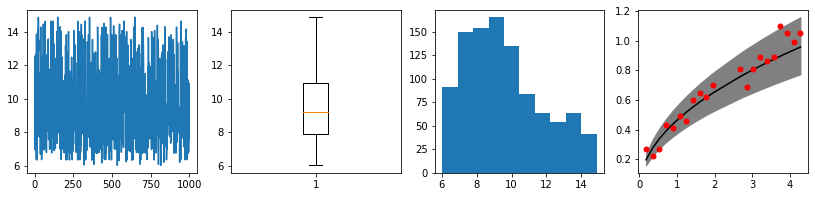

In [10]:
obsvar = np.maximum(0.2*y, 0.1)

# Fit a calibrator with emulator 1 via via method = 'directbayes' and 'sampler' = 'metropolis_hastings' 
cal_1 = calibrator(emu=emulator_1,
                   y=y,
                   x=x_std,
                   thetaprior=prior_balldrop, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={'theta0': np.array([[0.4]]), 
                         'numsamp' : 1000, 
                         'stepType' : 'normal', 
                         'stepParam' : [0.3]})

plot_pred(x_std, x, y, cal_1, theta_range)

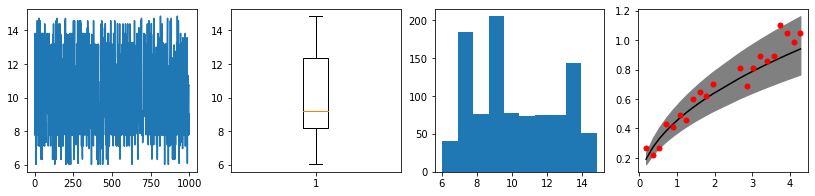

In [11]:
# Fit a calibrator via method = 'directbayes' and 'sampler' : 'LMC'
cal_2 = calibrator(emu=emulator_1,
                   y=y,
                   x=x_std,
                   thetaprior=prior_balldrop, 
                   method='directbayeswoodbury',
                   yvar=obsvar)

plot_pred(x_std, x, y, cal_2, theta_range)